# Trabalho 1 - Introdução ao Aprendizado de Máquina
## Aluno: Vinicius Almeida Alves

## Introdução
Neste trabalho utilizarei técnicas e procedimentos de aprendizado de máquina para tentar estimar o valor de um imóvel a partir de um histórico de outros imóveis. 
Os dados são provenientes do site Kaggle, que é um portal de competições em Data Science. Logo, utilizarei estes dados históricos e tentarei estimar o valor de venda de novas casas. Enviarei minhas estimativas para o Kaggle que deverá calcular um erro e me ranquear na competição.
Competição: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
Perfil: https://www.kaggle.com/viniciusalves

# Pré-Processamento dos Dados

Nesta etapa, carregarei os dados e os transformarei, de forma a poder utilizar técnicas de Regressão numérica. Logo, todos os dados devem ser traduzidos em quantidades numéricas, mesmo os categóricos.

## Imports

In [1]:
import numpy as np
import pandas as pd
import time
import scipy.sparse as sps
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from IPython.core.display import HTML

# Carregando os dados

In [2]:
df_train = pd.read_csv('./data/train.csv', encoding='utf8')
df_test  = pd.read_csv('./data/test.csv' , encoding='utf8')

# Visualizando os dados
Há cerca de 80 colunas com atributos para cada resiência vendida, tais como: rua, bairro, tipo de garagem, área, etc

In [3]:
exibir_dataframe = lambda dataframe: display(HTML(dataframe.head(5).to_html()))
exibir_dataframe(df_train)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Identificando colunas
É importante separar as colunas em numéricas e categóricas, pois serão processadas de formas distintas.

In [4]:
numeric_columns     = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',      \
                       'YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',   \
                       '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',    \
                       'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces',   \
                       'GarageYrBlt','GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',\
                       '3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

categorical_columns = ['MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',    \
                       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',    \
                       'RoofStyle','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond',    \
                       'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2', \
                       'Heating','HeatingQC','CentralAir','Electrical','KitchenQual', 'Functional',     \
                       'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive',\
                       'PoolQC','Fence','MiscFeature','SaleType','SaleCondition']

exibir_dataframe(df_train[categorical_columns])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


# Preenchendo dados faltantes com a mediana
Há diversos campos sem informação nos dados carregados, para possibilitar o processamento escolhi preenche-los com a mediana, pois esta não é fortemente afetada por outliers, ou seja, imóveis com atributos incomuns, como uma casa pequena com valor exorbitante, etc.

In [5]:
for column in numeric_columns:
    serie_all_data = pd.concat([df_train[column],df_test[column]])
    df_test[column].fillna(value=serie_all_data.median(), inplace=True)
    df_train[column].fillna(value=serie_all_data.median(), inplace=True)
    print("Dados faltantes de coluna "+ column +" preenchidos com "+str(serie_all_data.median()))

Dados faltantes de coluna MSSubClass preenchidos com 50.0
Dados faltantes de coluna LotFrontage preenchidos com 68.0
Dados faltantes de coluna LotArea preenchidos com 9453.0
Dados faltantes de coluna OverallQual preenchidos com 6.0
Dados faltantes de coluna OverallCond preenchidos com 5.0
Dados faltantes de coluna YearBuilt preenchidos com 1973.0
Dados faltantes de coluna YearRemodAdd preenchidos com 1993.0
Dados faltantes de coluna MasVnrArea preenchidos com 0.0
Dados faltantes de coluna BsmtFinSF1 preenchidos com 368.5
Dados faltantes de coluna BsmtFinSF2 preenchidos com 0.0
Dados faltantes de coluna BsmtUnfSF preenchidos com 467.0
Dados faltantes de coluna TotalBsmtSF preenchidos com 989.5
Dados faltantes de coluna 1stFlrSF preenchidos com 1082.0
Dados faltantes de coluna 2ndFlrSF preenchidos com 0.0
Dados faltantes de coluna LowQualFinSF preenchidos com 0.0
Dados faltantes de coluna GrLivArea preenchidos com 1444.0
Dados faltantes de coluna BsmtFullBath preenchidos com 0.0
Dados fa

# Criando listas para armazenar resultado do pré-processamento
Estruturas para carregar o resultado

In [6]:
matrizes_train_resultado = []
matrizes_test_resultado  = []

# Processamento de colunas categóricas
Cada coluna categórica pssará por hotEncoded, ou seja, caso a coluna tenha valores possíveis A, B e C, serão geradas três colunas para cada imóvel, estas serão preenchidas com 0 ou 1, informando se o imóvel é daquele tipo ou não. Porém tal procedimento cria uma coluna linearmente dependente, algo que pode atrapalhar a convergência de alguns algoritmos de aprendizado de máquna, portanto deve-se remover uma das colunas da matriz gerada.

In [7]:
def dropcols_coo(M, idx_to_drop):
    # Apaga coluna idx_to_drop em matriz esparsa M
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    M = None
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))
    return C.tocsr()

num_linhas_treino = df_train.shape[0]
 
def hotEncodar(column, apagar_coluna_antiga = True):
    
    df_all_data = pd.DataFrame()
    df_all_data[column] = pd.concat([df_train[column],df_test [column]],copy=False)    
    df_all_data[column] = df_all_data[column].astype(str, copy = False)
    
     # fit labels
    label_enc = preprocessing.LabelEncoder() 
    label_enc.fit(df_all_data[column])
    
    # transform labels
    column_label_encoded = label_enc.transform(df_all_data[column]).reshape(-1,1) 
    df_all_data = None
        
    # fit e transform usando OneHotEncoder
    one_hot_enc = OneHotEncoder(sparse=True)
    column_transformed = one_hot_enc.fit_transform(column_label_encoded)
    
    # particionando resultado
    train_column_transformed = column_transformed[:num_linhas_treino]
    test_column_transformed  = column_transformed[num_linhas_treino:]
    column_transformed = None
    
    # removendo coluna linearmente dependente do resultado
    indice_ultima_coluna = train_column_transformed.shape[1]-1
    train_column_transformed = dropcols_coo(train_column_transformed, indice_ultima_coluna) 
    indice_ultima_coluna = test_column_transformed.shape[1]-1
    test_column_transformed = dropcols_coo(test_column_transformed, indice_ultima_coluna)
    
    # apagando colunas antigas
    df_train.drop(columns=[column], inplace=True)
    df_test.drop(columns=[column], inplace=True)
    
    # Salvando matrizes de resultado
    matrizes_train_resultado.append(train_column_transformed)
    matrizes_test_resultado.append(test_column_transformed)
    
    print('Coluna '+column+' transformada em '+str(one_hot_enc.n_values_[0] -1) +' colunas linearmente independentes')
    
for column in categorical_columns:
    hotEncodar(column)

# Limpando memória
train_column_transformed = None
test_column_transformed  = None

Coluna MSZoning transformada em 5 colunas linearmente independentes
Coluna Street transformada em 1 colunas linearmente independentes
Coluna Alley transformada em 2 colunas linearmente independentes
Coluna LotShape transformada em 3 colunas linearmente independentes
Coluna LandContour transformada em 3 colunas linearmente independentes
Coluna Utilities transformada em 2 colunas linearmente independentes
Coluna LotConfig transformada em 4 colunas linearmente independentes
Coluna LandSlope transformada em 2 colunas linearmente independentes
Coluna Neighborhood transformada em 24 colunas linearmente independentes
Coluna Condition1 transformada em 8 colunas linearmente independentes
Coluna Condition2 transformada em 7 colunas linearmente independentes
Coluna BldgType transformada em 4 colunas linearmente independentes
Coluna HouseStyle transformada em 7 colunas linearmente independentes
Coluna RoofStyle transformada em 5 colunas linearmente independentes
Coluna Exterior1st transformada em 

# Normalização dos dados
Os algoritmos de aprendizado são sensíveis às escalas dos parâmetros, ou seja, se há um parâmetro com valores muito maior que  os outros, isso pode diminuir a performance da ferramenta. Logo, antes de iniciar o processamento é útil escalar os dados. Utilizei o MinMaxScaler, pois não afetaria o resultado das colunas categóricas, portanto só precisaria aplicar nas numéricas.

In [8]:

df_all_data = pd.concat([df_train[numeric_columns],df_test[numeric_columns]],copy=False)

# Escalando colunas numéricas 
scaler = MinMaxScaler(copy=False)
scaler.fit(df_all_data[numeric_columns])
train_matriz_scaled = scaler.transform(df_train[numeric_columns])
test_matriz_scaled  = scaler.transform(df_test[numeric_columns])
    
# Salvando matrizes de resultado
matrizes_train_resultado.append(train_matriz_scaled)
matrizes_test_resultado.append(test_matriz_scaled)

# Concatenando Matrizes esparsas para o resultado
Utilizo matrizes esparsas para armazenar os resultados, que são estruturas em memória altamente eficientes para matrizes nas quais a maior porção dos elementos é composta por zeros.

In [9]:
# Matrizes esparsas
matriz_train = sps.hstack(matrizes_train_resultado).tocsr()
matriz_test  = sps.hstack(matrizes_test_resultado).tocsr()

print("Dimensões da matriz de treino: "+str(matriz_train.shape[0])+"x"+str(matriz_train.shape[1]))
print("Dimensões da matriz de teste: "+str(matriz_test.shape[0])+"x"+str(matriz_test.shape[1]))

Dimensões da matriz de treino: 1460x261
Dimensões da matriz de teste: 1459x261


# Regressão

Nesta etapa os dados processados serão repassados a regressores, e com validação cruzada poderei observar o desempenho destes. 

## Imports

In [10]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

vetor_train_target = df_train['SalePrice']

## Configuração da validação cruzada (k-Fold)
O k-Fold é uma técnica que funciona de forma a dividir o conjunto de treino em n partições mutuamente exclusivas, de forma que se possa analisar a performance n vezes, alternando o conjunto de teste a ser testado em cada iteração. Com isso, para cada algoritmo a ser testado, produzi um histograma exibindo as performances de forma global, o dado de interesse é a média dessas performances, pois deve se aproximar do valor calculado pelo kaggle.

In [11]:
#np.random.seed(0) - random_state

# A validação cruzada é feita através de análise de partições pequenas
# e mutuamente exclusivas dos datasets originais

# Quantidade de divisões a serem usadas pelo k-fold
n_splits = 50

# Regressor Linear
O regressor mais básico é o próprio regressor Linear, após ele também utilizo alguns outros.
A avaliação do regressor se dá pela comparação entre o valor predito e pelo valor real, para isso estou utilizando a raíz quadrática média do logaritmo dos valores de vendas das casas. Pois é o mesmo critério que o kaggle utiliza na avaliação.

Tempo de processamento do regressor linear: 57.38s


RMSE MEAN:  0.1667
RMSE STD:   0.1210 




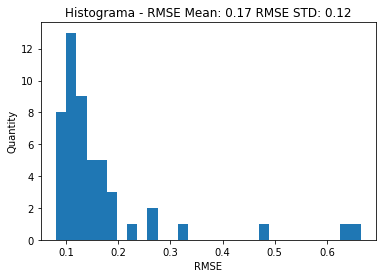

In [12]:
from sklearn.linear_model import LinearRegression

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor Linear
    regr = LinearRegression(n_jobs = -1)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor linear: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor Ridge

Tempo de processamento do regressor Ridge: 12.89s


RMSE MEAN:  0.1337
RMSE STD:   0.0494 




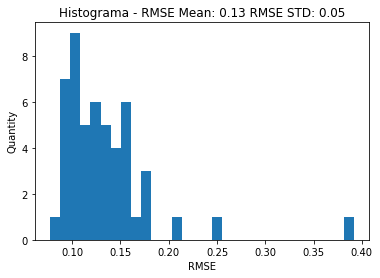

In [13]:
from sklearn.linear_model import Ridge

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor Ridge
    # Este alpha foi escolhido variando seu valor, até obter o melhor RMSE
    regr = Ridge(alpha = 3.0, fit_intercept=True)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor Ridge: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# SVM Regressor

Tempo de processamento do regressor SVM: 399.61s


RMSE MEAN:  0.1331
RMSE STD:   0.0649 




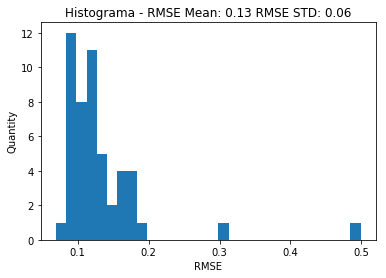

In [14]:
from sklearn.svm import SVR

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando SVM Regressor
    # o kernel linar foi escolhido após testes com os outros kernels
    regr = SVR('linear')
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor SVM: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor KNN

Tempo de processamento do regressor KNN: 341.78s


RMSE MEAN:  0.2105
RMSE STD:   0.0419 




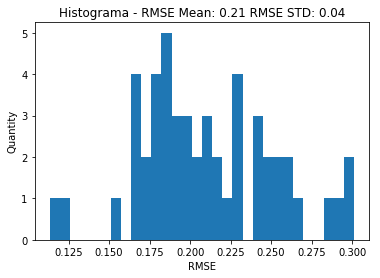

In [15]:
from sklearn.neighbors import KNeighborsRegressor

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor KNN
    regr =  KNeighborsRegressor(n_jobs=-1, n_neighbors=30)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor KNN: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor RandomForest

Tempo de processamento do regressor RandomForest: 202.77s


RMSE MEAN:  0.1484
RMSE STD:   0.0320 




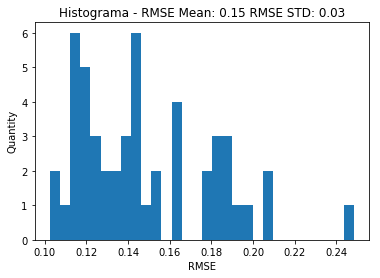

In [16]:
from sklearn.ensemble import RandomForestRegressor

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor RandomForest
    regr =  RandomForestRegressor()
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor RandomForest: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Regressor GradientBoosting

Tempo de processamento do regressor GradientBoosting: 177.52s


RMSE MEAN:  0.2292
RMSE STD:   0.0423 




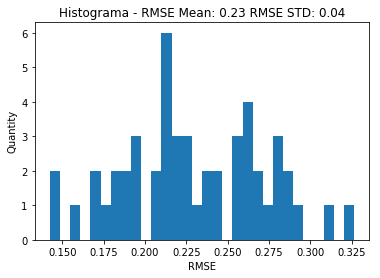

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

start = time.time()

rmse_list =[]
X = matriz_train
y = np.log(vetor_train_target)

kf = KFold(n_splits=n_splits);

# Validação cruzada    
for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
        
    # Criando Regressor GradientBoosting
    regr =  GradientBoostingRegressor(learning_rate = 0.01)
    
    # Treino
    regr.fit(X_train, y_train) 
    
    # Predição     
    y_pred = regr.predict(X_test)
    
    #Root mean squared error
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)));

end = time.time()

print('Tempo de processamento do regressor GradientBoosting: '+str("%.2f" % (end - start))+'s\n\n')
print("RMSE MEAN: ","%.4f" % np.mean(rmse_list))
print("RMSE STD:  ","%.4f" % np.std(rmse_list), '\n\n')

plt.title(u"Histograma - RMSE Mean: " + str("%.2f" % np.mean(rmse_list))+ " RMSE STD: " + str("%.2f" % np.std(rmse_list)))
plt.ylabel("Quantity")
plt.xlabel("RMSE")

plt.hist(rmse_list,bins = 30)
plt.show()

# Utilizando regressor em dados de teste
O regressor que apresentou melhor desempenho foi o Ridge, com alpha = 3.0. Portanto, utilizarei ele com todas as amostras de treino, e a partir disso obtereri uma estimativa do valor de venda para os imóveis de teste, em seguida produzindo um arquivo de submissão a ser enviado para o kaggle para ser avaliado.

In [18]:
X_train = matriz_train
y_train = vetor_train_target
X_test  = matriz_test

# Criando Regressor Ridge
regr = Ridge(alpha = 3.0, fit_intercept=True)

# Treino
regr.fit(X_train, y_train) 

# Predição      
y_pred = regr.predict(X_test)

# Salvando o resultado

In [19]:
df_y_pred = pd.DataFrame(y_pred, columns = ['SalePrice'])
df_resultado = pd.concat([df_test["Id"],df_y_pred],axis =1)
df_resultado.to_csv('submission.csv', encoding='utf-8', index=False)
exibir_dataframe(df_resultado)

# Conclusão
Utilizando as ferramentas e técnicas de aprendizado de máquina, consegui gerar estimativas para o valor de venda de novas casas baseado no histórico de vendas de casas antigas. Obtive um erro médio quadrático logarítmico de 0.15 no Kaggle.